In [3]:
import glob

bussiness_files = glob.glob("data/emails/business/*")
personal_files = glob.glob("data/emails/personal/*")

In [5]:
from data_preprocessing import clean_noise
mail_list = []

for file in bussiness_files:
    with open(file) as f:
        mail_text = f.readlines()
        cleaned_text = clean_noise(mail_text)
        mail_list.append({"text": cleaned_text, "type": 1})
        
for file in personal_files:
    with open(file) as f:
        mail_text = f.readlines()
        cleaned_text = clean_noise(mail_text)
        mail_list.append({"text": cleaned_text, "type": 0})

In [6]:
import pandas as pd
tweets = pd.read_csv('data/gender-classifier-DFE-791531.csv', index_col=0, header=0, encoding="utf-8")
tw_list = tweets['text'].tolist()

added = set()
for tw in tw_list:
    if len(added) >= 3000:
        break
    if tw not in added:
        mail_list.append({"text": tw, "type": 0})
        prev = tw
        added.add(tw)

In [7]:
import pandas as pd

df = pd.DataFrame(data=mail_list)


In [8]:
from data_preprocessing import preprocess
df['text'] = df['text'].map(preprocess)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(sublinear_tf=True, lowercase=False, min_df=5, norm='l2', ngram_range=(1, 2))
features = tfidf_vect.fit_transform(df.text).toarray()

In [10]:
labels = df.type

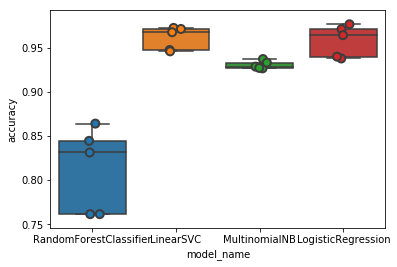

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='f1', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


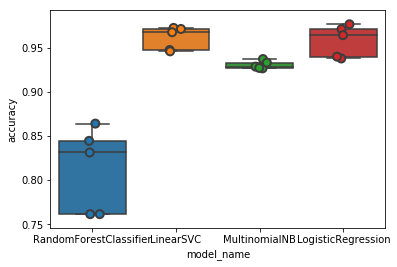

In [12]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [14]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.960929
LogisticRegression        0.957946
MultinomialNB             0.930561
RandomForestClassifier    0.812688
Name: accuracy, dtype: float64

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

SVC_pipeline = Pipeline([
                ('tfidf', tfidf_vect),
                ('clf', CalibratedClassifierCV(LinearSVC())),
            ])


X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(df.text, labels, df.index, 
                                                                                 test_size=0.33, random_state=0)
SVC_pipeline.fit(X_train, y_train)
y_proba = SVC_pipeline.predict_proba(X_test)


In [18]:
print("Train accuracy is: {:.2f}".format(SVC_pipeline.score(X_train, y_train)))
print("Test accuracy is: {:.2f}".format(SVC_pipeline.score(X_test, y_test)))


Train accuracy is: 1.00


Test accuracy is: 0.97


In [ ]:
from sklearn.externals import joblib
joblib.dump(SVC_pipeline, 'classification_model.pkl')